In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
wordcloud_stopwords = set(STOPWORDS)

from tqdm import tqdm
from ufal.udpipe import Model, Pipeline, ProcessingError
import conllu
from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
m = Model.load("english-gum-ud-2.5-191206.udpipe")
pipeline_tokenize = Pipeline(m, 'tokenize', Pipeline.DEFAULT, Pipeline.NONE, 'conllu')
error = ProcessingError()

In [4]:
df = pd.read_csv('Shoes_Data.csv')
df['float_price'] = [float(df['price'].loc[i][1:]) for i in range(len(df['price']))]

### Анализ данных

In [5]:
# статистика цен
df.describe()

,float_price
count,1230.000000
mean,2031.842268
std,1729.425360
min,127.000000
25%,622.250000
50%,1588.000000
75%,2844.687500
max,7992.000000


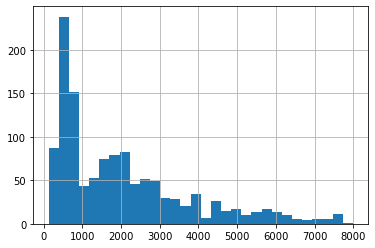

In [6]:
# цены на графике
df['float_price'].hist(bins=30)
plt.show()

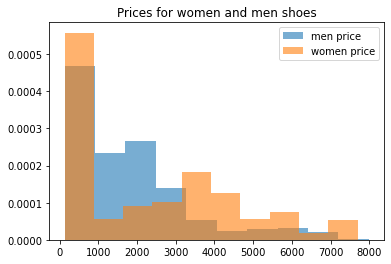

In [7]:
# разброс цен на мужскую и женскую обувь
men_prices = df[df['Shoe Type'] == 'Men']['float_price']
women_prices = df[df['Shoe Type'] == 'Women']['float_price']

plt.hist(men_prices, alpha=0.6, density=True, label='men price')
plt.hist(women_prices, alpha=0.6, density=True, label='women price')
plt.legend()
plt.title('Prices for women and men shoes')
plt.show()

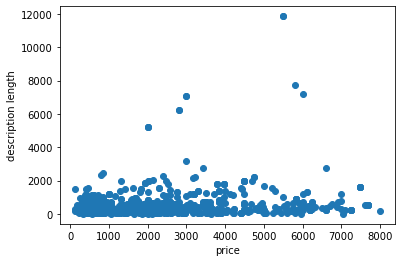

In [8]:
# зависимость длины описания и цены
descr_lens = [len(df['product_description'].loc[i][1:]) for i in range(len(df['product_description']))]

plt.scatter(df['float_price'], descr_lens)
plt.xlabel('price')
plt.ylabel('description length')
plt.show()

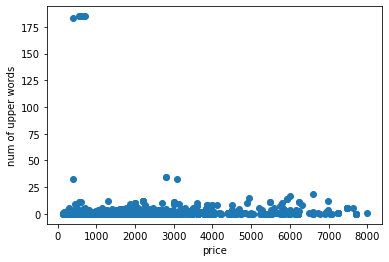

In [9]:
# зависиомость количества слов капсом в описании и цены
upper_words_counts = []
for desc in df['product_description']:
    words = desc.split(' ')
    count = 0
    for word in words:
        if word.isupper():
            count += 1
    upper_words_counts.append(count)
    
plt.scatter(df['float_price'], upper_words_counts)
plt.xlabel('price')
plt.ylabel('num of upper words')
plt.show()

#### Несколько замечаний:
* Большая часть обуви имеет цену до 1000.
* Женская обувь в целом дороже мусжкой, и разброс цен больше, так как цены на мужскую обувь в основном до 4000.
* Зависимостей между длиной описания и ценой, количеством слов в верхнем регистре и ценой не было обнаружено, поэтому добавлять эти признаки не будем. 

#### Посмотрим, стоит ли добавлять другие признаки

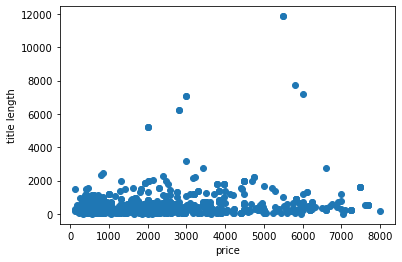

In [10]:
# зависимость длины заголовка и цены
title_lens = [len(df['title'].loc[i][1:]) for i in range(len(df['title']))]

plt.scatter(df['float_price'], descr_lens)
plt.xlabel('price')
plt.ylabel('title length')
plt.show()

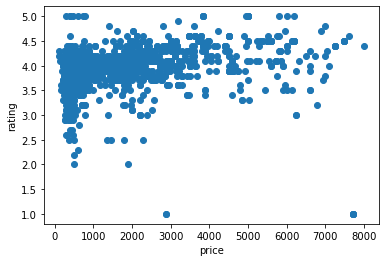

In [11]:
# зависимость рейтинга и цены
df['float_rating'] = [float(df['rating'].loc[i][:-15]) for i in range(len(df['rating']))]

plt.scatter(df['float_price'], df['float_rating'])
plt.xlabel('price')
plt.ylabel('rating')
plt.show()

* Зависимостей между длиной заголовка и цены, рейтинга товара и цены не обнаружено, поэтому эти признаки тоже использоавать не будем.

#### Облака слов для 25% снизу по цене и 25% сверху (для дешевых и дорогих)

Цифры для выделения дорогих и дешевых товаров взяты и статистики цен выше. 

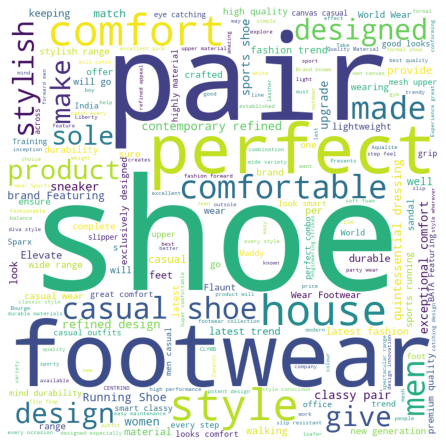

In [12]:
cheap_descriptions = df[df['float_price'] < 622]['product_description'].to_list()
cheap_descriptions_str = ' '.join(cheap_descriptions)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = wordcloud_stopwords,
                min_font_size = 8).generate(cheap_descriptions_str)
 
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

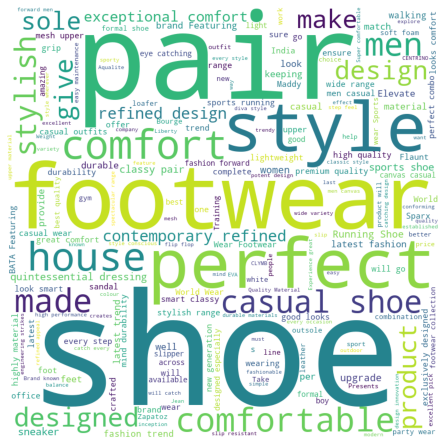

In [13]:
expensive_descriptions = df[df['float_price'] > 2844]['product_description'].to_list()
expensive_descriptions_str = ' '.join(cheap_descriptions)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = wordcloud_stopwords,
                min_font_size = 8).generate(expensive_descriptions_str)
 
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Подготовка данных

* Слова лемматизируются, приводятся к нижнему регистру
* Удаляются стоп слова и пунктуация - я проводила эксперименты без их удаления, с удалением качество было лучше
* В tf-idf беру только самые частотные 1000 слов, чтобы не создавать лишних признаков

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
def lemmatize(text, drop_punct=False):
    if error.occurred():
        print(error.message)
    conllu_text = pipeline_tokenize.process(text, error)
    sentences = conllu.parse(conllu_text)
    lemmas = []
    for sent in sentences:
        for token in sent:
            if drop_punct:
                if token['upos'] == 'PUNCT':
                    continue
            lemmas.append(token['lemma'])
    return lemmas

In [16]:
train_lemmas = []
for desc in tqdm(df_train['product_description']):
    lemmas = lemmatize(desc, drop_punct=True)
    clean_lemmas = [lemma.lower() for lemma in lemmas if lemma.lower() not in stop_words]
    train_lemmas.append(clean_lemmas)
    
test_lemmas = []
for desc in tqdm(df_test['product_description']):
    lemmas = lemmatize(desc, drop_punct=True)
    clean_lemmas = [lemma.lower() for lemma in lemmas if lemma.lower() not in stop_words]
    test_lemmas.append(clean_lemmas)

100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:02<00:00, 95.22it/s]


In [17]:
train_lemmatized = [' '.join(lemmas) for lemmas in train_lemmas]
test_lemmatized = [' '.join(lemmas) for lemmas in test_lemmas]
all_lemmatized = train_lemmatized + test_lemmatized

In [21]:
count_vectorizer = CountVectorizer(max_features=1000)
count_vectorizer.fit(all_lemmatized)
train_count = count_vectorizer.transform(train_lemmatized)
test_count = count_vectorizer.transform(test_lemmatized)

linear = LinearRegression().fit(train_count.toarray(), df_train['float_price'])
pred = linear.predict(test_count.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 7.912874811582824e+28
Mean absolute: 82407066493306.9
R2: -2.8821050671649016e+22


In [22]:
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(all_lemmatized)
train_tfidf = vectorizer.transform(train_lemmatized)
test_tfidf = vectorizer.transform(test_lemmatized)

linear = LinearRegression().fit(train_tfidf.toarray(), df_train['float_price'])
pred = linear.predict(test_tfidf.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 9.050666457116248e+30
Mean absolute: 1326647167043807.2
R2: -3.2965227276300516e+24


### GridSearch

#### with CountVectorizer

In [24]:
model = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['positive'] = [True, False]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_count.toarray(), df_train['float_price'])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -1028.6452584873127
Best Hyperparameters: {'fit_intercept': True, 'normalize': False, 'positive': True}


In [25]:
pred = result.predict(test_count.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 1303647.6108325813
Mean absolute: 862.9452571277941
R2: 0.5251726490758886


In [26]:
model = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_count.toarray(), df_train['float_price'])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -778.6165136581016
Best Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'normalize': False, 'solver': 'lsqr'}


In [27]:
pred = result.predict(test_count.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 1159483.437403616
Mean absolute: 731.2056989760558
R2: 0.5776815418154854


In [28]:
model = Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['positive'] = [True, False]
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_count.toarray(), df_train['float_price'])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -849.1331253945314
Best Hyperparameters: {'alpha': 1, 'fit_intercept': True, 'normalize': False, 'positive': False}


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8398364.79596436, tolerance: 299425.2031145718
  model = cd_fast.enet_coordinate_descent(


In [29]:
pred = result.predict(test_count.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 1937652.9001131994
Mean absolute: 819.5906690320402
R2: 0.29424900876121163


#### with TfidfVectorizer

In [54]:
model = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['positive'] = [True, False]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_tfidf.toarray(), df_train['float_price'])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -756.9528739692645
Best Hyperparameters: {'fit_intercept': False, 'normalize': True, 'positive': True}


In [55]:
pred = result.predict(test_tfidf.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 1475000.276567532
Mean absolute: 778.8120682029104
R2: 0.4627608963379315


In [57]:
model = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_tfidf.toarray(), df_train['float_price'])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -689.2693009375461
Best Hyperparameters: {'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [58]:
pred = result.predict(test_tfidf.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 1208405.013981954
Mean absolute: 702.8416703553746
R2: 0.5598628441730391


In [59]:
model = Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['positive'] = [True, False]
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_tfidf.toarray(), df_train['float_price'])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -734.770844133553
Best Hyperparameters: {'alpha': 1, 'fit_intercept': True, 'normalize': True, 'positive': False}


In [60]:
pred = result.predict(test_tfidf.toarray())
print('Mean squared:', mean_squared_error(df_test['float_price'], pred))
print('Mean absolute:', mean_absolute_error(df_test['float_price'], pred))
print('R2:', r2_score(df_test['float_price'], pred))

Mean squared: 1179284.783804589
Mean absolute: 745.4316469802501
R2: 0.5704693007327131


#### Ridge regression на данных векторизованных с помощью Tf-Idf показала лучшие результаты (MAE = 702)

Ridge regression отличается от обычной линейной регрессии тем, что стремится уменьшить коэффициенты при параметрах, поэтому она справилась с этой задачей лучше. Но не очень понятно, почему Lasso regression не оказалась еще лучше, чем Ridge, потому что она способна отсеивать неважные параметры. Видимо, бесполезных параметром в нашей задаче не оказалось - мы и так отбросили часть при векторизации.

### Анализ качества лучшей модели

In [70]:
ridge_best_params = Ridge(alpha=0.1, fit_intercept=True, normalize=True, solver='sag')
best_model = ridge_best_params.fit(train_tfidf.toarray(), df_train['float_price'])

best_pred = best_model.predict(test_tfidf.toarray())

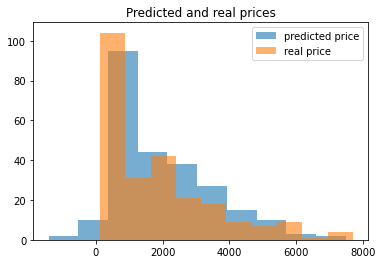

In [63]:
plt.hist(best_pred, alpha=0.6, label='predicted price')
plt.hist(df_test['float_price'], alpha=0.6, label='real price')
plt.legend()
plt.title('Predicted and real prices')
plt.show()

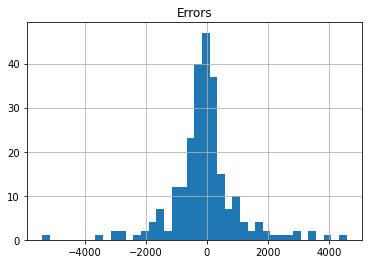

In [162]:
(df_test['float_price'] - best_pred).hist(bins=40)
plt.title('Errors')
plt.show()

#### Из двух графиков выше видно, что  
* предсказанные цены могут быть отрицательными, этого не может быть с реальными ценами  
* у модели нет тенденции занижать/завышать цены, ошибки случаются в обе стороны

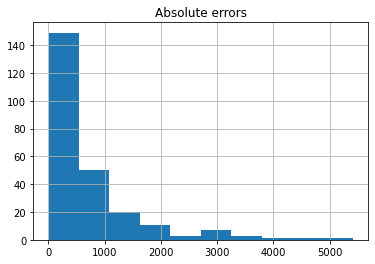

In [81]:
np.abs(df_test['float_price'] - best_pred).hist()
plt.title('Absolute errors')
plt.show()

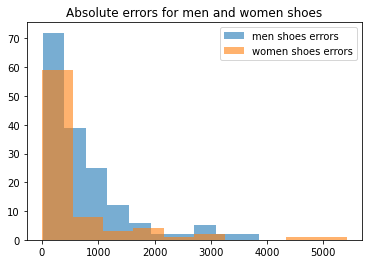

In [87]:
men_indices = np.where(df_test['Shoe Type'] == 'Men')
women_indices = np.where(df_test['Shoe Type'] == 'Women')
men_error = np.abs(df_test['float_price'].iloc[men_indices] - best_pred[men_indices])
women_error = np.abs(df_test['float_price'].iloc[women_indices] - best_pred[women_indices])

plt.hist(men_error, alpha=0.6, label='men shoes errors')
plt.hist(women_error, alpha=0.6, label='women shoes errors')
plt.legend()
plt.title('Absolute errors for men and women shoes')
plt.show()

#### Два графика выше показывают, что
* большая часть ошибок лежит в интервале до 1000 - это довольно большие ошибки, так как цены на обувь варьируются от 127 до 7992.
* есть некоторое количество очень больших ошибок (те, что больше 1000), интересно изучить, в каких случаях они возникают.
* ошибки предсказания цен женской обуви в целом меньше, однако самые большие ошибки (около 5000) возникли на женской обуви.

------

#### Изучим слова, которые больше/меньше всего влияют на предсказание

In [166]:
sorted_coef_indices = np.argsort(best_model.coef_)
features = np.array(vectorizer.get_feature_names())
expensive_features = features[sorted_coef_indices][-10:]
expensive_coefs = best_model.coef_[sorted_coef_indices][-10:]
cheap_features = features[sorted_coef_indices][:10]
cheap_coefs = best_model.coef_[sorted_coef_indices][:10]

In [172]:
print('Слова, сильнее остальных повышающие предсказанную цену:')
for i in range(len(expensive_features)):
    print(f'{expensive_features[i]}: {expensive_coefs[i]:.2f}')

Слова, повышающие предсказанную цену:
badminton: 4522.92
ർമ: 4630.52
key: 4672.24
moc: 4743.24
stretch: 5348.67
vision: 5390.01
skech: 5717.54
piece: 5823.89
inch: 5985.47
cooled: 6935.93


In [173]:
print('Слова, сильнее остальных уменьшающие предсказанную цену:')
for i in range(len(cheap_features)):
    print(f'{cheap_features[i]}: {cheap_coefs[i]:.2f}')

Слова, уменьшающие предсказанную цену:
pillar: -4988.70
tone: -4737.15
sculpt: -4354.42
effect: -4116.50
two: -4113.56
relief: -4020.44
accord: -3985.63
tear: -3548.07
pull: -3480.28
italian: -3073.50


In [179]:
unimportant_indices = np.where((best_model.coef_ < 50) & (best_model.coef_ > -50))
unimportant_features = features[unimportant_indices]
print(f'Слова, которые меньше всего влияют на предсказанную цену:\n{", ".join(unimportant_features)}')

Слова, которые меньше всего влияют на предсказанную цену:
55, ______reebok, along, apparel, bold, bring, catching, closure, cushioned, customize, demographic, energy, excitement, exclusively, explore, feature, finish, foam, football, fu8545, goodyear, gymm, help, highly, horblu, keep, last, length, men, mood, open, parties, poker, prevent, renew, research, running, spread, sturdy, superior, traction, trgry1, true, workout, wrap, इनस, इल, கள, பர, வட, வம, ఇన, తమ, థట, ವರ, രണ, ളത, ർത


#### Самые важные для предсказаний слова довольно рандомные.
* Конечно, можно попытаться объяснить, что например обувь для бадминтона и обувь, способная хорошо растягиваться, обычно стоит дороже, а итальянская обувь обычно стоит очень дешево. Все-таки больше похоже на то, что модель переобучилась и поэтому поставила этим словам такие высокие коэффициенты.

#### Посмотрим на случаи, в которых ошибка оказалась самой большой

In [181]:
errors = np.abs(df_test['float_price'] - best_pred)
print(f'Индексы примеров с самой высокой ошибкой: {np.where(errors > 4000)}')

Индексы примеров с самой высокой ошибкой: (array([102, 230], dtype=int64),)


In [188]:
print(f"TEXT 1:\n\n{df_test.iloc[102]['product_description']}\n")
print(f"Predicted price: {pred[102]}, Real price: {df_test.iloc[102]['float_price']}")

TEXT 1:

BMCiTYBM toddler shoes - Your steps our concern_________When you take your kids to do outdoor activities all you worry about is how to avoid injuries and how to make little toes keep comfort______But most of toddler shoes can’t really doing baby’s feet any favors______Show kids a big love by giving them a pair of cozy and fuctional shoes to play happier______Kids will love the feeling of BMCiTYBM toddler shoes______And the helmet-type toe cap will protect little toes from injuries through rough kicking and feet dragging_________Why choose the toddler shoes?_________1. BMCiTYBM has been the best selling toddler shoes brand on Tmall. All products are made of high quality materials with excellent craftsmanship______2. Original and unique design being a most shining kid in the crowd______3. Odor-free materials and skin-friendly keep little feet healthy______4. Helmet-type toe cap protects kids from injuries through rough kicking and feet dragging______5. Lightweight and non-slip s

In [187]:
print('Слова, которые сильнее всего повлияли на предсказанную цену в тексте выше:')
used = np.where(test_tfidf[102].toarray() != 0)[1]
for ind in used:
    if np.abs(best_model.coef_[ind]) > 1000:
        print(f"{features[ind]}: {best_model.coef_[ind]:.2f}")

Слова, которые сильнее всего повлияли на предсказанную цену в тексте выше:
accord: -3985.63
big: -1987.34
brand: -1511.16
choose: 2143.06
deliver: 1083.67
feet: -1114.13
free: 1101.41
good: -1246.08
hour: 1660.00
inner: -2093.36
kid: -1160.19
lightweight: -1358.13
make: 1000.50
play: -1329.73
protect: 1557.01
shoe: -1553.18
shoes: -1261.50
slip: -1024.51


In [189]:
print(f"TEXT 2:\n\n{df_test.iloc[230]['product_description']}\n")
print(f"Predicted price: {pred[230]}, Real price: {df_test.iloc[230]['float_price']}")

TEXT 2:

Carlton Family is a multinational group established in 1989.In 1992 Carlton London was founded with a great vision to bring quality fashion to the footwear Industry.

Predicted price: 6277.66628046775, Real price: 331.0


In [190]:
print('Слова, которые сильнее всего повлияли на предсказанную цену в тексте выше:')
used = np.where(test_tfidf[230].toarray() != 0)[1]
for ind in used:
    if np.abs(best_model.coef_[ind]) > 1000:
        print(f"{features[ind]}: {best_model.coef_[ind]:.2f}")

Слова, которые сильнее всего повлияли на предсказанную цену в тексте выше:
group: 1131.14
industry: 1211.67
vision: 5390.01


#### Из анализа выше видим, что
* Первый текст получил цену значительно ниже реальной, потому что в нем попалось много слов с отрицательным коэффициентом. Например, **accord** из нашего же списка "особо влиятельных слов"
* Для второго текста предсказанная цена оказалась значительно выше преальной. В тексте встретилось слово с огромным положительным коэффициентом - **vision**

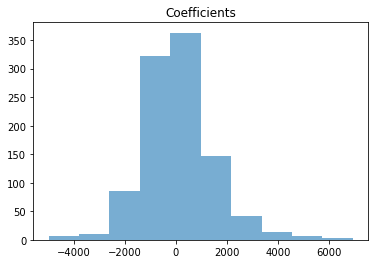

In [191]:
plt.hist(best_model.coef_, alpha=0.6)
plt.title('Coefficients')
plt.show()

### Итог

Линейные модели плохо справляются с предсказанием по текстовым данным. Модель не смогла понять по tf-idf, какие слова самые важные для дешевой и дорогой обуви, поэтому самые влиятельные для модели слова оказались почти рандомными. 

#### Еще захотелось проверить, выделяются ли какие-то осмысленные слова, которые есть только у дорогой и только у дешевой обуви, сделаем это с помощью использованных фичей tf-idf

Видим, что
* Хинди (?) встречается в описаниях дорогой обуви.
* Названия брендов встречаются также для дорогой обуви: **adidas, reebok, asics, skechers**.
* Дорогая обувь чаще описывается через технические особенности: **engineer, engineered, cloudfoam, innovate...**, а дешевая оценивается с точки зрения внешнего вида: **elegant, bold, fashionable...**
* У дорогих встречаются слова **luxe, elite**

Но много и слов, которые не дают определить ценовую категорию. Кроме того, слова взяты из 25% нижних и верхних примеров, а 50% по середине различить с помощью слов будет еще сложнее.

In [202]:
cheap_ind = np.where(df_train['float_price'] < 622)
cheap_tfidf = train_tfidf.toarray()[cheap_ind[0]]
all_cheap_features = []
for t in cheap_tfidf:
    used = np.where(t != 0)
    all_cheap_features.extend(features[used])
all_cheap_features = set(all_cheap_features)

In [204]:
exp_ind = np.where(df_train['float_price'] > 2844)
exp_tfidf = train_tfidf.toarray()[exp_ind[0]]
all_exp_features = []
for t in exp_tfidf:
    used = np.where(t != 0)
    all_exp_features.extend(features[used])
all_exp_features = set(all_exp_features)

In [207]:
common = set.intersection(all_exp_features, all_cheap_features)

In [214]:
print('Only in cheap shoes descriptions: \n')
print(', '.join(set(all_cheap_features) - set(common)))

Only in cheap shoes descriptions: 

neighborhood, along, going, strain, office, among, exclusively, fashionable, lt, known, pvc, leg, pothole, blend, always, slipper, flip, presents, display, accord, centrino, sturdy, party, jean, dare, maddy, bata, absolute, wherever, body, weather, elegance, catwalk, especially, guarantee, dust, longwalk, this, grocery, signify, spectacular, million, potent, vinyl, ___, shoefly, fabulous, matter, conform, shopping, canva, acetate, jogge, unmatched, stunn, bore, etc, fall, elegant, canvas, combo, elastic, inner, sega, sneakers, role, trendy, simple, instruction, zapatoz, benchmark, nature, stylecolour, home, business, geeky, mind, breezy, flavia, shoes, suitable, ethylene, emphasi, amazing, denim, bourge, lotto, campus, cozy, bold, attention, diva, outfit, behavior, solace, youth, liberty, demand, blue, footwears, stereotype, resistant, cloud, trp, basis, relaxo, tpr, inception, runn, available, school, sparx


In [215]:
print('Only in expensive shoes descriptions: \n')
print(', '.join(set(all_exp_features) - set(common)))

Only in expensive shoes descriptions: 

instantly, develop, നല, heritage, ఎగ, इन, யப, इनस, arena, అల, engineer, chief, lallyer, stripe, belief, kobe, யற, height, snug, கள, odor, యవ, नल, court, ఓవర, anti, compression, next, രത, centre, star, cloudfoam, stand, டன, வம, global, antoine, eliminat, enabl, കമ, ______skechers, athlete, అదనప, renew, genuine, യപ, midfoot, contour, mizuno, దత, softfoam, ಗಳ, కర, renow, inspire, lateral, വൽ, articulated, goodyear, item, difference, track, kohli, യത, selena, benefits, लर, ஏர, ஓவர, ரக, అప, features, रक, visible, கப, propel, நட, ఆన, virat, cell, ಅನ, strive, engineered, maximum, आउटस, రత, relax, ஒர, sockliner, టర, association, ఇన, proprietary, plush, ഷൻ, உச, animal, आपक, ತನ, reebok, പർ, functionality, रद, വഴക, oz, வட, spread, ಅಕ, revolutionise, incredible, story, wrap, worldwide, పర, ஆதரவ, innovate, pad, ളത, sleek, mix, striker, ignite, luxe, nearly, strength, solid, രണ, എയർ, rely, பர, രദമ, excitement, டம, planet, അധ, gel, contact, supportive, मद, coun